Time 1.1827997080000001


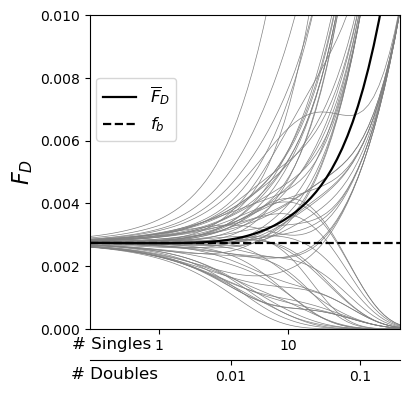

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import timeit
from matplotlib.ticker import MultipleLocator

# Setting a random seed ensures reproducibility of results
np.random.seed(42)


# Function to compute FD
@nb.njit()
def analytics(t, fs, fd, mus, mud):
    ns, nd = len(fs), len(fd)
    Ps, Pd = np.zeros(ns+1), np.zeros(nd)
    fs[::-1].sort(), fd[::-1].sort()

    for i in range(ns):
        Ps[i] = (1 - np.exp(-t * mus)) * np.exp(-t * mus * i)
    Ps[ns] = np.exp(-t * mus *ns)

    for i in range(nd):
        Pd[i] = (1 - np.exp(-t * mud)) * np.exp(-t * mud * i)

    H = np.zeros((ns+1, nd))
    for i in range(ns):
        for j in range(nd):
            H[i, j] = fs[i] < fd[j]
    H[ns] = 1

    FD = np.dot(Ps,np.dot(H, Pd))/(1-np.exp(-t*(ns*mus+nd*mud)))
    #FD = np.dot(Ps,np.dot(H, Pd))
    return FD


# Parameter initializations
ns = 12
nd = 20
#alpha = 3*10**(-2)
alpha = 4*10**(-3)
mus = 1
mud = mus*alpha
mus = mus*3*0.76/5.89
mud = mud*3*0.99*0.52/9.63
landscapes = 100
datapoints = 60
tmin = 10**(-1.2)
tmax = 10**(1.2)

# Create logarithmically spaced array for mutation supply
T = np.logspace(np.log10(tmin), np.log10(tmax), num=datapoints, base=10)

# Initialize matrix to store all computed FD values across different landscapes
all_y = np.zeros((landscapes, datapoints))

start = timeit.default_timer()
for l in range(landscapes):
    fs = np.random.random(size=ns)
    fd = np.random.random(size=nd)

    y = np.zeros(len(T))
    for i in range(len(T)):
        y[i] = analytics(T[i], fs, fd, mus, mud)
    all_y[l] = y
stop = timeit.default_timer()
print("Time", stop-start)

# Plotting
fig = plt.figure(figsize=(4.2,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

# Plot individual FD curves for each landscape in gray
for i in range(60):
    ax1.plot(T, all_y[i], color="gray", lw=0.5)
ax1.plot(T, all_y[83], color="gray", lw=0.5)

# Plot mean FD curve and f_b
ax1.plot(T, all_y.mean(axis=0), color="black", lw=1.6, label='$\\overline{F}_D$')
ax1.plot(T, [nd*(mud)/(nd*mud+ns*mus)]*len(T),"--", color="black", lw=1.6, label='$f_b$')

ax1.set_xscale("log")

# Set the x-ticks
ax1.set_xticks([1/(mus*ns), 10/(mus*ns), 100/(mus*ns), 1000/(mus*ns), 10000/(mus*ns)])
ax1.set_xticklabels([1, 10, 100, 1000, 10000])

# Set x-tick labels
ax1.tick_params(axis='x', labelsize=10)
ax1.set_xlabel("# Singles", fontsize=12)


ax2.set_xscale("log")
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))

# Turn on the frame for the twin axis, but then hide all
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)

for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)


# Set the x-ticks for the second axis
ax2.set_xticks([0.01/(mud*nd),0.1/(mud*nd),1/(mud*nd),10/(mud*nd),100/(mud*nd),1000/(mud*nd),10000/(mud*nd)])
ax2.set_xticklabels([0.01,0.1, 1, 10, 100, 1000, 10000])

# Set the fontsize for x-tick labels of the second axis
ax2.tick_params(axis='x', labelsize=10)


ax2.set_xlabel("# Doubles", fontsize=12)

ax1.xaxis.set_minor_locator(MultipleLocator(10000))
ax2.xaxis.set_minor_locator(MultipleLocator(10000))

ax1.xaxis.set_label_coords(.069, -.024)
ax2.xaxis.set_label_coords(.08, -.12)

#plt.ylim(0.0, 0.07)
plt.ylim(0.0, 0.010)
#plt.ylim(0.001, 0.02)
ax1.set_xlim(tmin,tmax)
ax2.set_xlim(tmin,tmax)
ax1.set_ylabel("$F_{D}$", fontsize=16)

ax1.legend(fontsize=12, loc=(0.02,0.6))
plt.tight_layout()
# plt.savefig('fig_A.pdf')

plt.show()